## Imports

In [1]:
import os
import torch
from torch import nn
import numpy as np
import matplotlib.pyplot as plt

if not 'have_changed_cwd' in globals():
    PROJECT_ROOT = os.path.abspath(os.path.join(os.getcwd(), '..'))
    os.chdir(PROJECT_ROOT)
    print(f"Working directory: {os.getcwd()}")
    have_changed_cwd = True


from src.models.classification.classifier import ImageClassifier
from src.dataset.cifar import CIFAR10DataModule
from src.models.autoencoding.autoencoder import Autoencoder

chkpt_path = "classifiers/resnet9-cifar10/2024-12-27/19-57-36/checkpoints/last.ckpt"
# chkpt_path = "classifiers/linear-cifar10/2024-12-27/20-41-01/checkpoints/last.ckpt"
classifier = ImageClassifier.load_from_checkpoint(chkpt_path)

chkpt_path = "autoencoders/convae-cifar10/2024-12-27/20-11-11/checkpoints/last.ckpt"
autoencoder = Autoencoder.load_from_checkpoint(chkpt_path)

datamodule = CIFAR10DataModule.get_default_dataset("cifar10", samples_per_class=100)

x, y = next(iter(datamodule.val_dataloader()))
N = 8
x = x[:N]
y = y[:N]

Working directory: /Users/mat/Desktop/Files/Code/Generative-Data-Augmentation
Files already downloaded and verified
Files already downloaded and verified


## Classifier Predictions

In [60]:
from src.eval.classification import inference_with_classifier

out = inference_with_classifier(classifier, datamodule.test_dataloader(), device='mps')

Doing inference on 16 batches on mps: 100%|██████████| 16/16 [00:00<00:00, 26.41it/s]


In [7]:
from sklearn.metrics import classification_report

print(classification_report(out['target'], out['pred'], target_names=datamodule.class_names))

In [8]:
from src.eval.classification import collect_misclassified, plot_image_grid
from matplotlib import pyplot as plt

misclassified_images, true_labels, pred_labels, pred_logits = collect_misclassified(classifier, datamodule.val_dataloader(), device='mps', num_samples=9)

In [9]:
plot_image_grid(misclassified_images, true_labels, pred_logits, class_names=datamodule.class_names)
plt.show()

## Autoencoder predictions

In [10]:
from src.eval.autoencoding import inference_with_autoencoder, collect_high_error_reconstructions, plot_reconstruction_pairs

out = inference_with_autoencoder(autoencoder, datamodule.test_dataloader(), device='mps')

In [11]:
plt.hist(out['mse_losses'], bins=100)
plt.title(f"Reconstruction Error Histogram (MSE) - mean: {out['mse_losses'].mean():.4f}")
plt.grid()
plt.show()

In [12]:
original_inputs, reconstructions, latent_codes, mse_values = collect_high_error_reconstructions(autoencoder, datamodule.test_dataloader(), device='mps', threshold=0.015, num_samples=9)

In [13]:
plot_reconstruction_pairs(original_inputs, reconstructions, num_pairs=5, figsize=(8, 8), mse_losses=mse_values)
plt.show()

## Gradients

### Pixel Space

In [ ]:
num_steps = 300
lr = 0.001
weight_decay = 0.01
optimizer_cls = torch.optim.AdamW

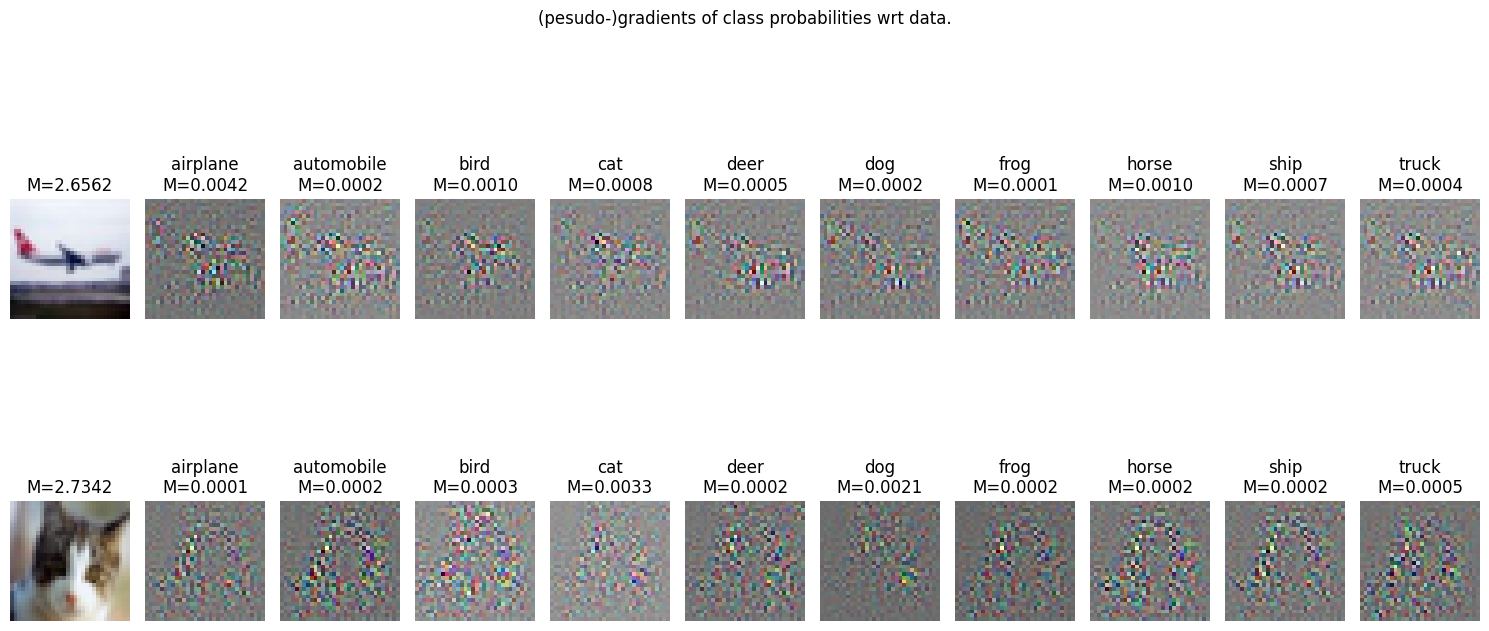

In [ ]:
from src.input_gradients import compute_proba_grads_wrt_data, plot_grads_wrt_data

grads, _ = compute_proba_grads_wrt_data(classifier, x.clone(), list(range(10)), device='mps')
plot_grads_wrt_data(x, grads, list(range(10)), datamodule.class_names)
plt.show()

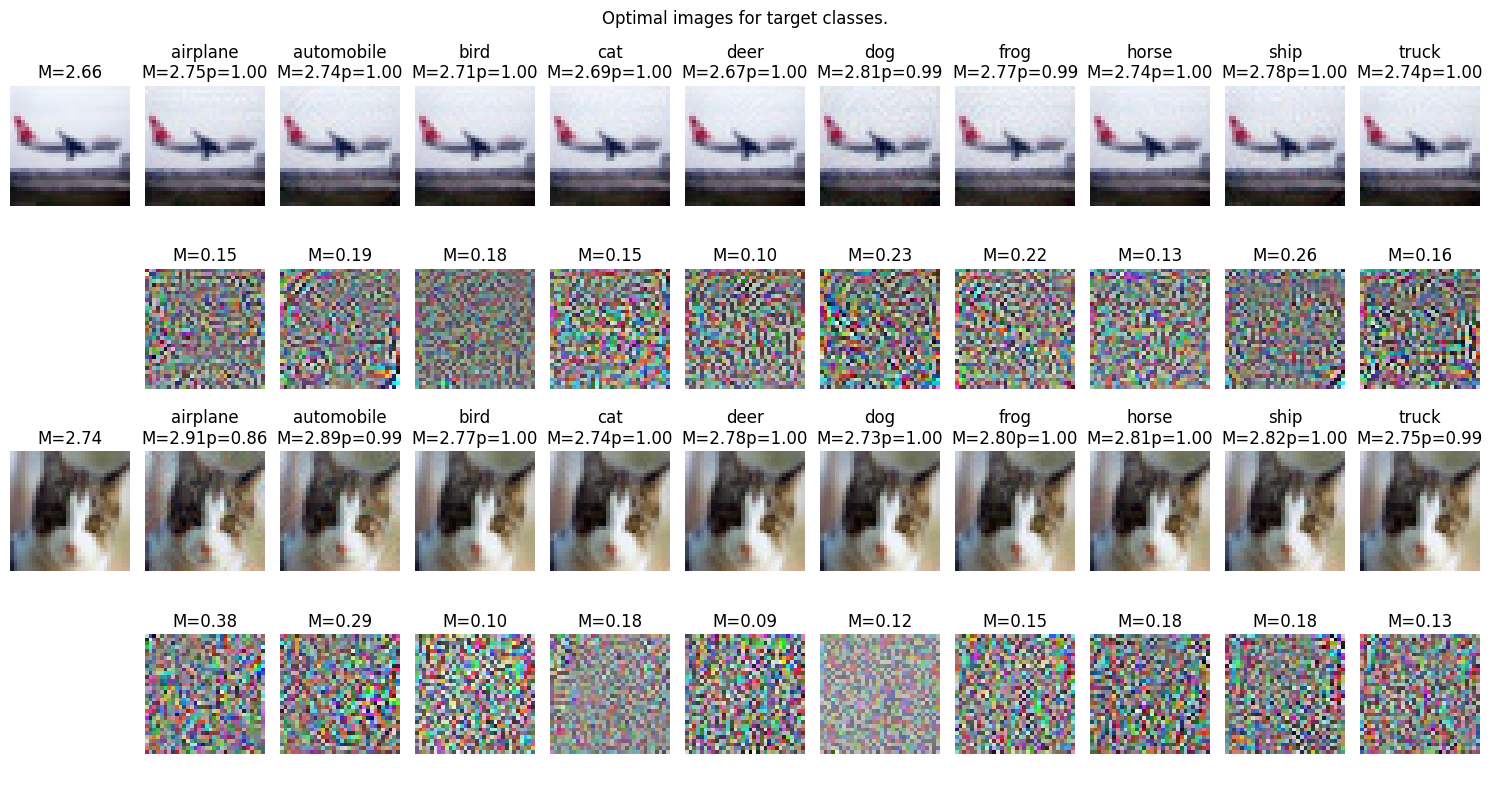

In [22]:
from src.input_gradients import optimize_proba_wrt_data, plot_optimal_images

config = {
    "num_steps": num_steps,
    "optimizer_cls": optimizer_cls,
    "save_k_intermediate_imgs": 10,
    "logit_transform": None,
    "optimizer_kwargs": {
        "lr": lr,
        "weight_decay": weight_decay,
    },
}

out = optimize_proba_wrt_data(
    classifier,
    x.clone(),
    list(range(10)),
    config,
    device='mps',
)
plot_optimal_images(out, datamodule.class_names)
plt.show()

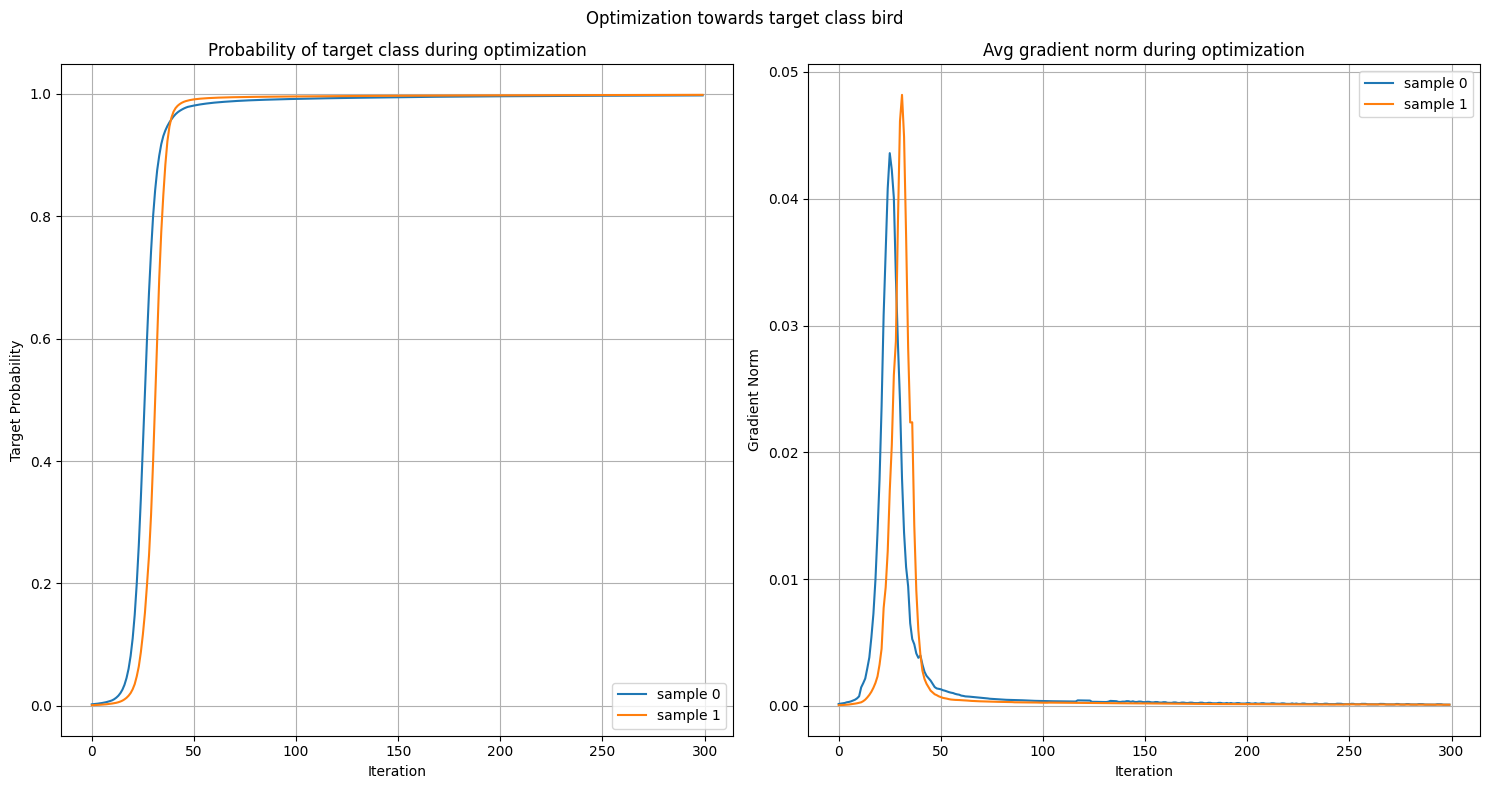

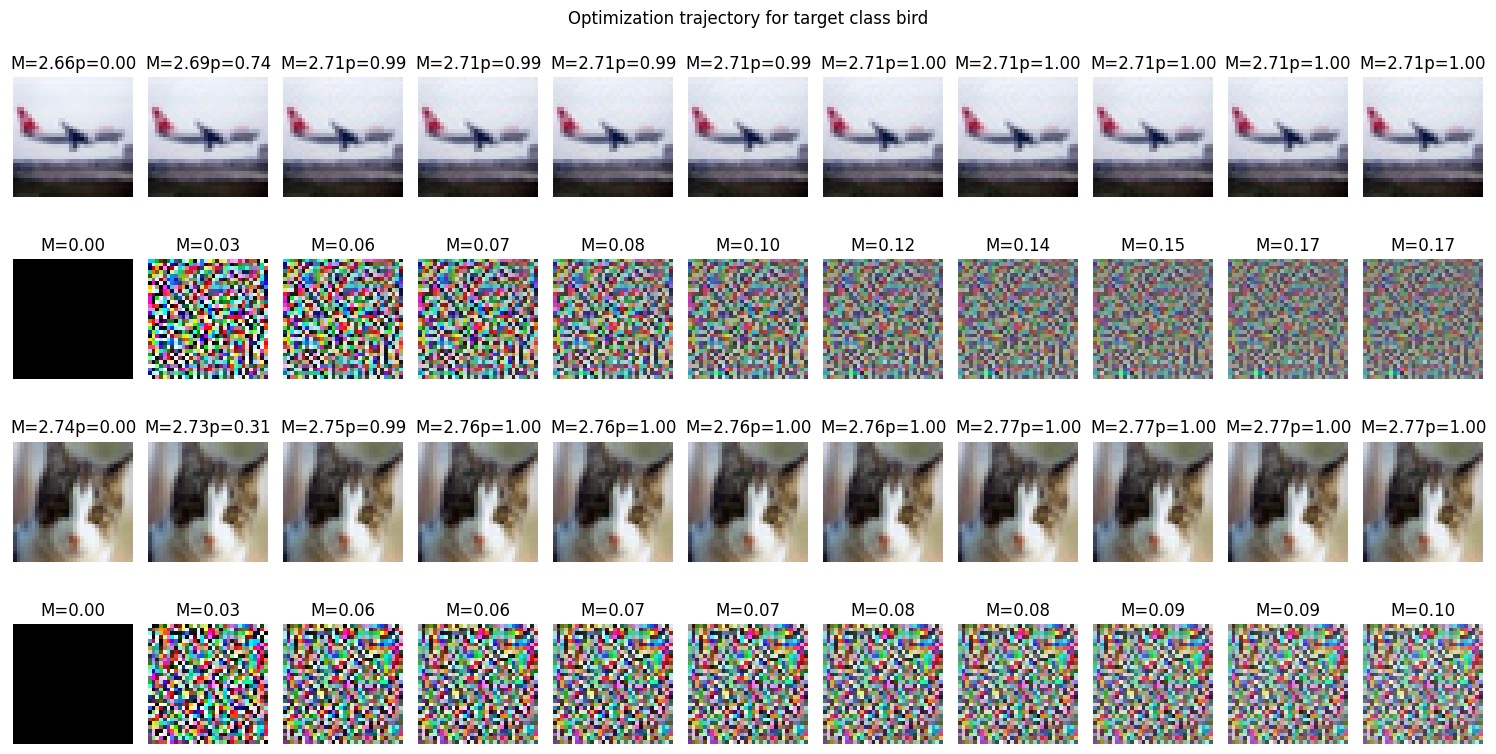

In [23]:
from src.input_gradients import plot_optimization_trajectory_fixed_sample, plot_optimization_trajectory_fixed_target

plot_optimization_trajectory_fixed_target(out, 2, datamodule.class_names)
plt.show()

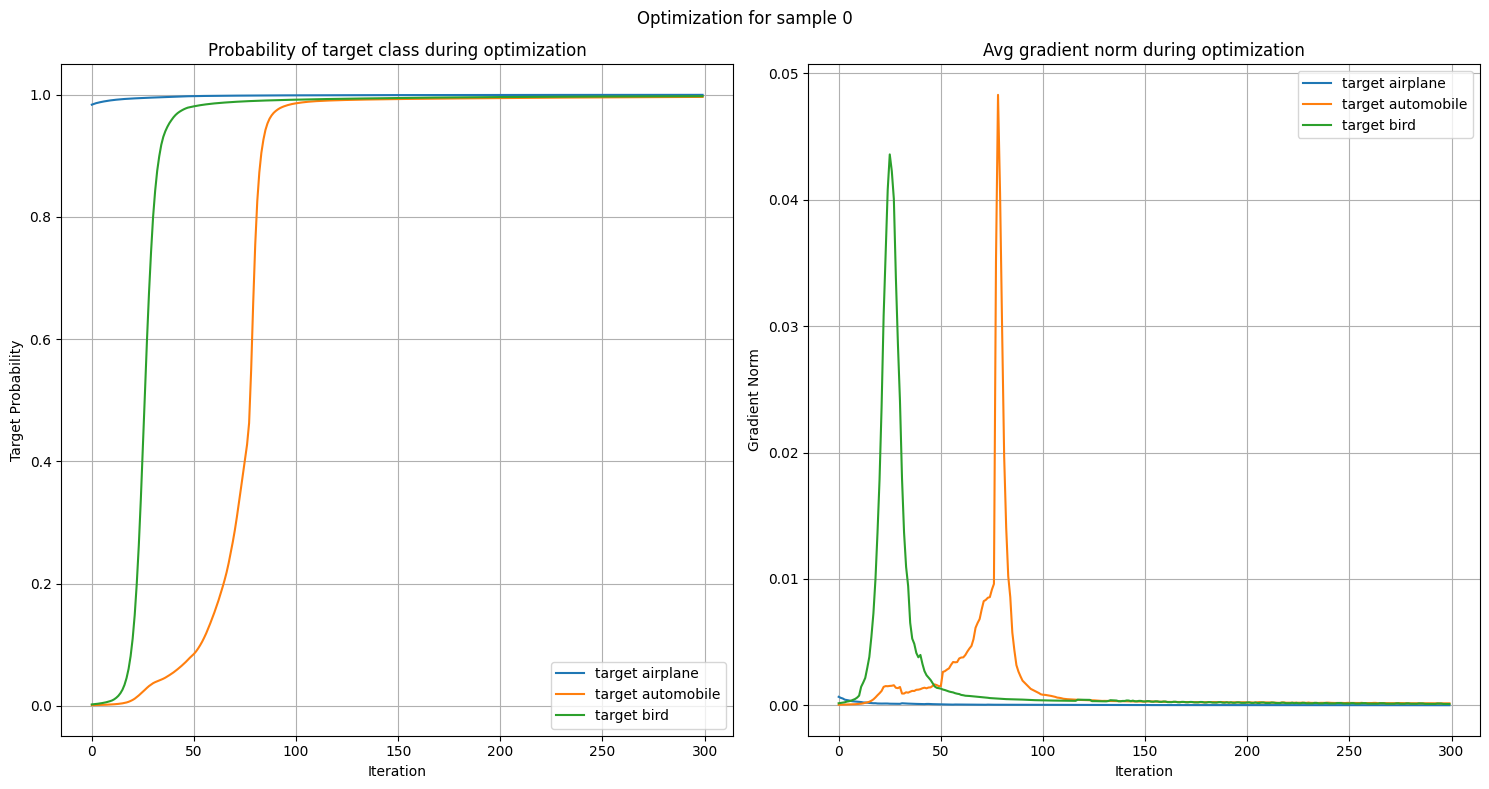

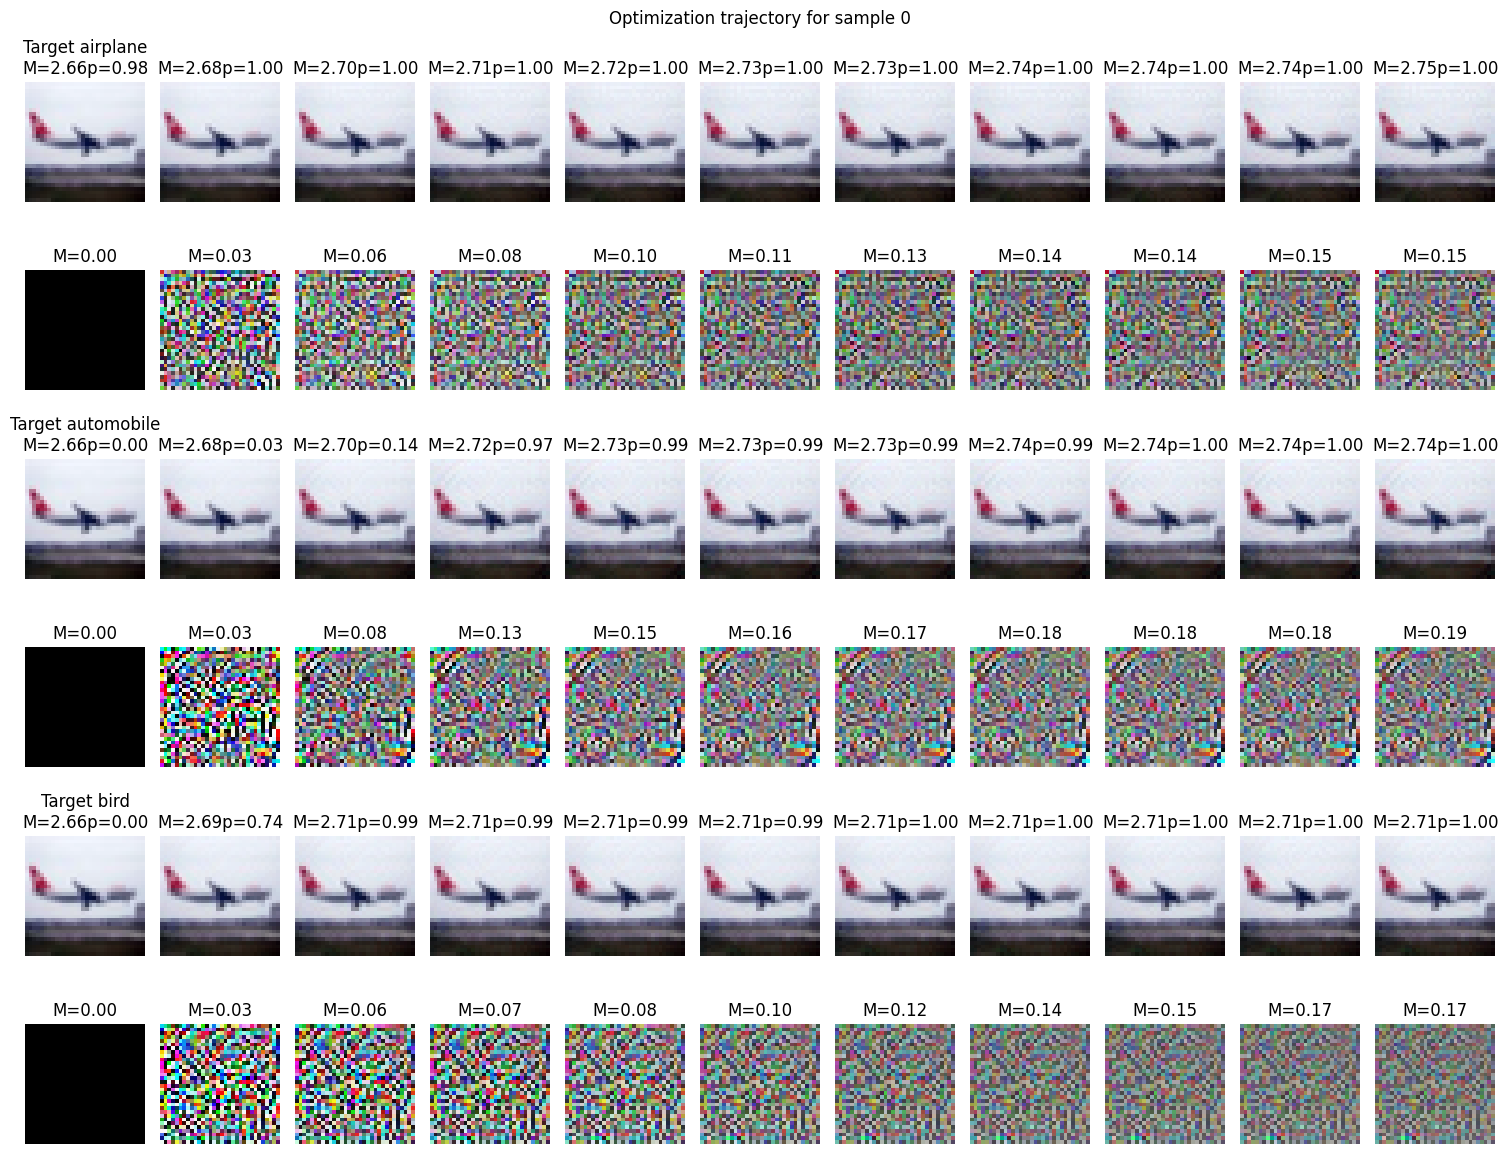

In [24]:
plot_optimization_trajectory_fixed_sample(out, 0, datamodule.class_names, targets=[0, 1, 2], figsizes=((15, 8), (15, 12)))
plt.show()

### Latent Space

In [38]:
num_steps = 500
lr = 0.001
weight_decay = 0.03
optimizer_cls = torch.optim.AdamW

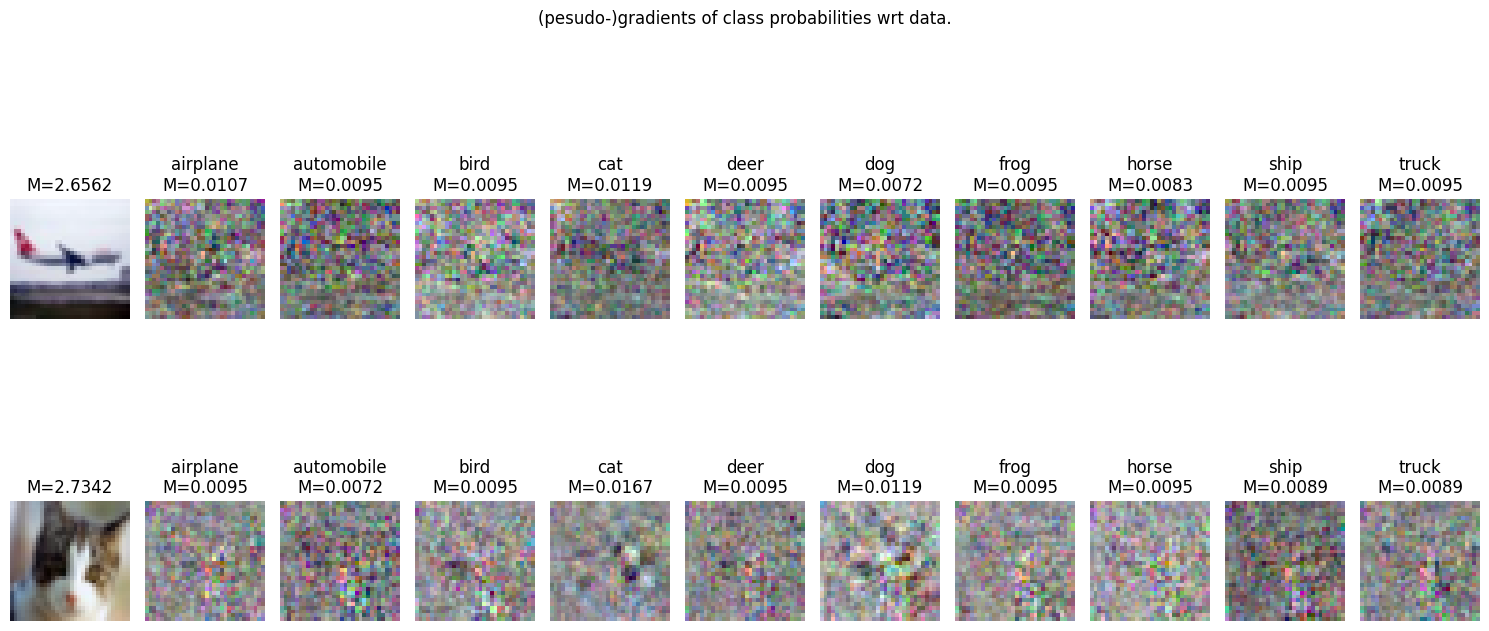

In [ ]:
from src.input_gradients import compute_proba_grads_wrt_data, plot_grads_wrt_data

grads, finite_diffs = compute_proba_grads_wrt_data(classifier, x.clone(), list(range(10)), device='mps', autoencoder=autoencoder, epsilon=0.0001)
plot_grads_wrt_data(x, finite_diffs, list(range(10)), datamodule.class_names)
plt.show()

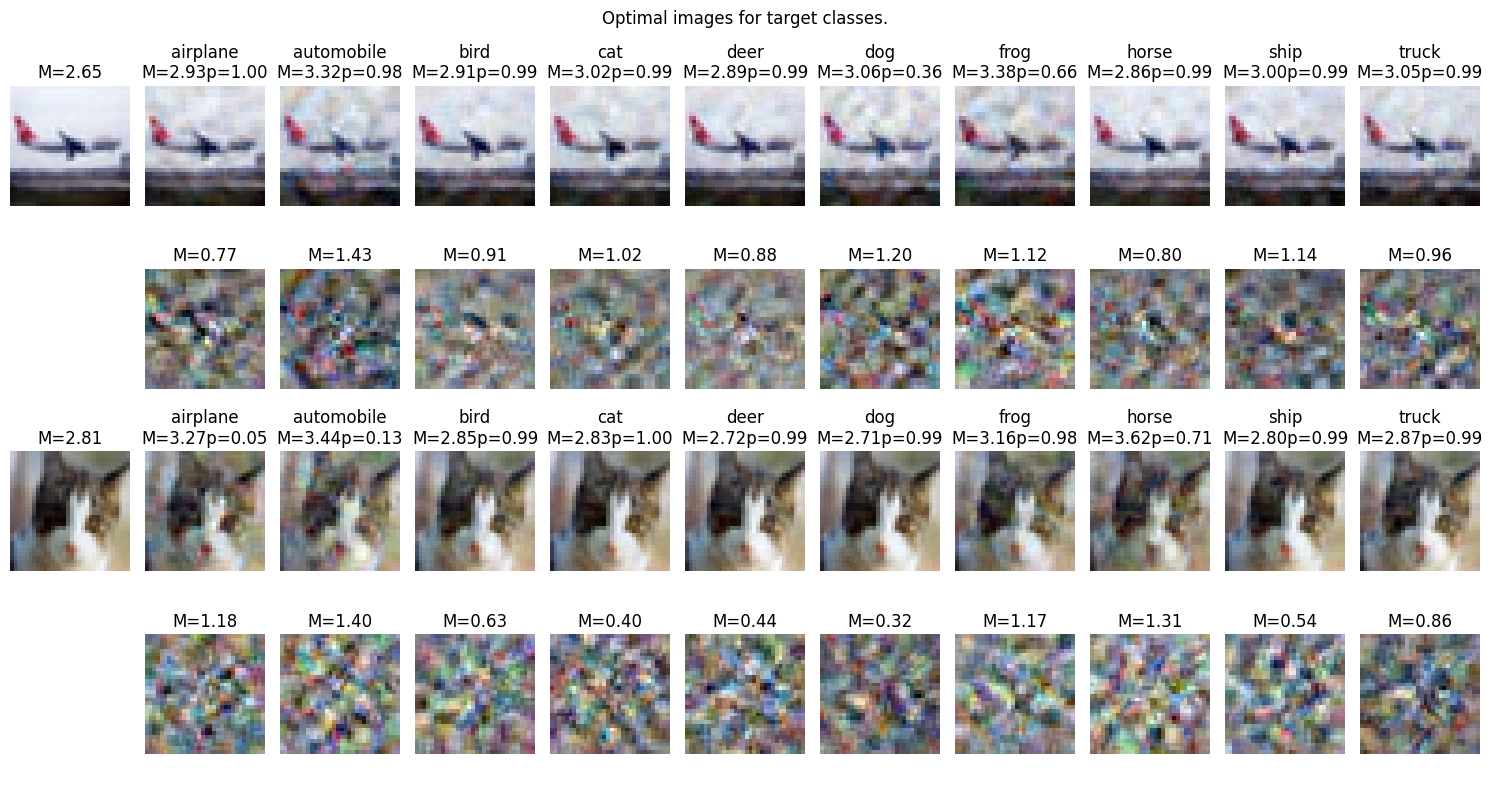

In [40]:
from src.input_gradients import optimize_proba_wrt_data, plot_optimal_images

config = {
    "num_steps": num_steps,
    "optimizer_cls": optimizer_cls,
    "save_k_intermediate_imgs": 10,
    "logit_transform": None,
    "optimizer_kwargs": {
        "lr": lr,
        "weight_decay": weight_decay,
    },
}

out = optimize_proba_wrt_data(
    classifier,
    x.clone(),
    list(range(10)),
    config,
    device='mps',
    autoencoder=autoencoder,
)
plot_optimal_images(out, datamodule.class_names)
plt.show()

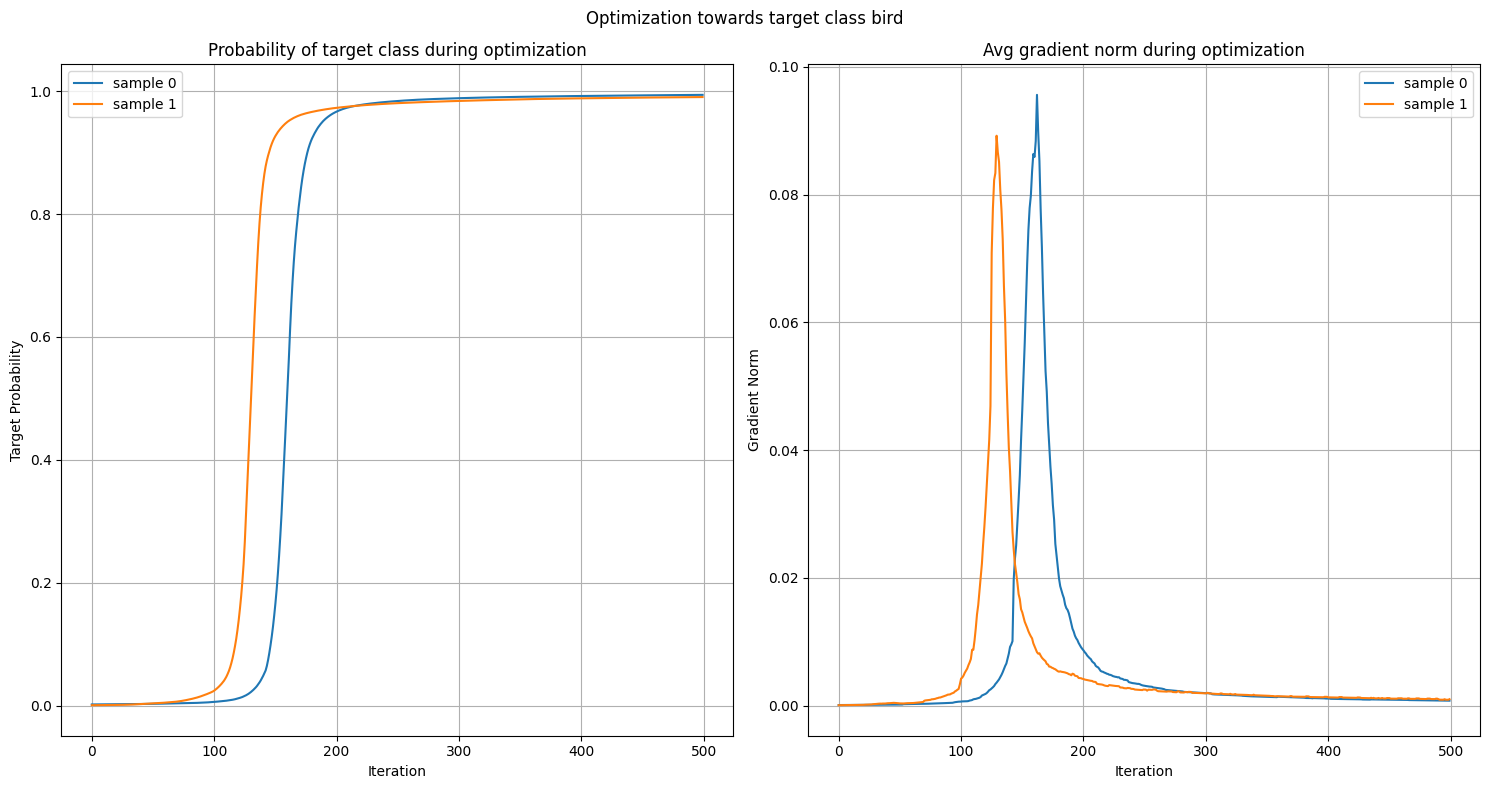

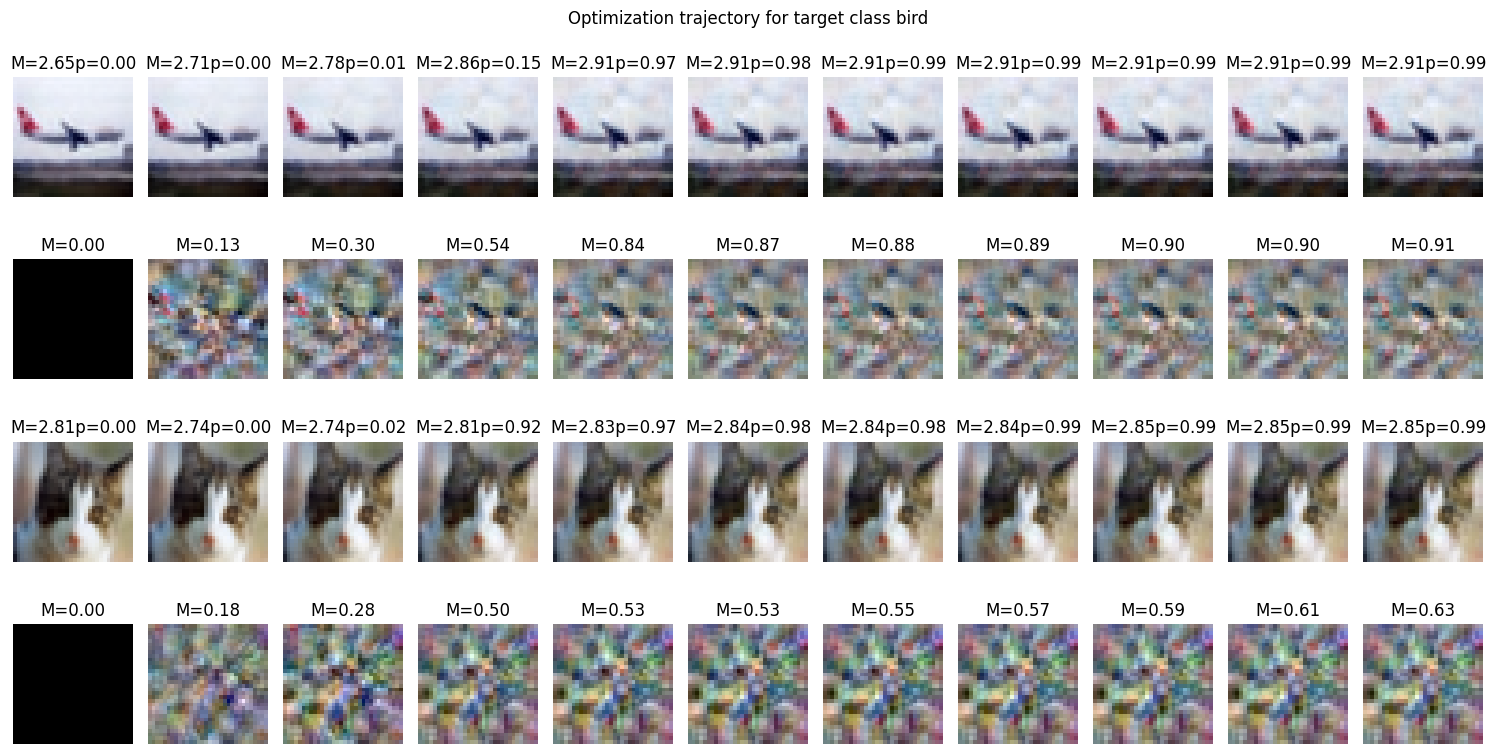

In [41]:
from src.input_gradients import plot_optimization_trajectory_fixed_sample, plot_optimization_trajectory_fixed_target

plot_optimization_trajectory_fixed_target(out, 2, datamodule.class_names)
plt.show()

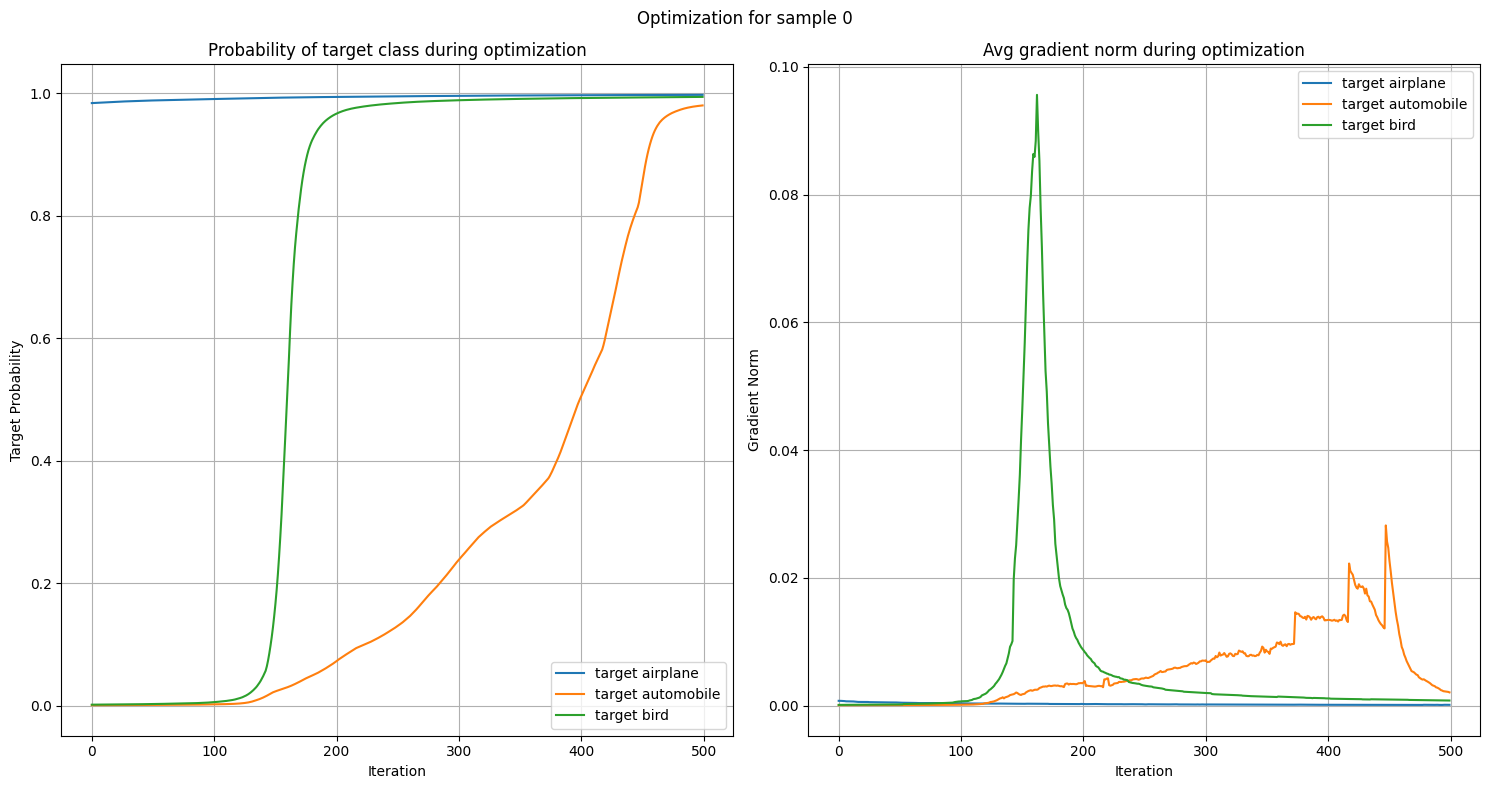

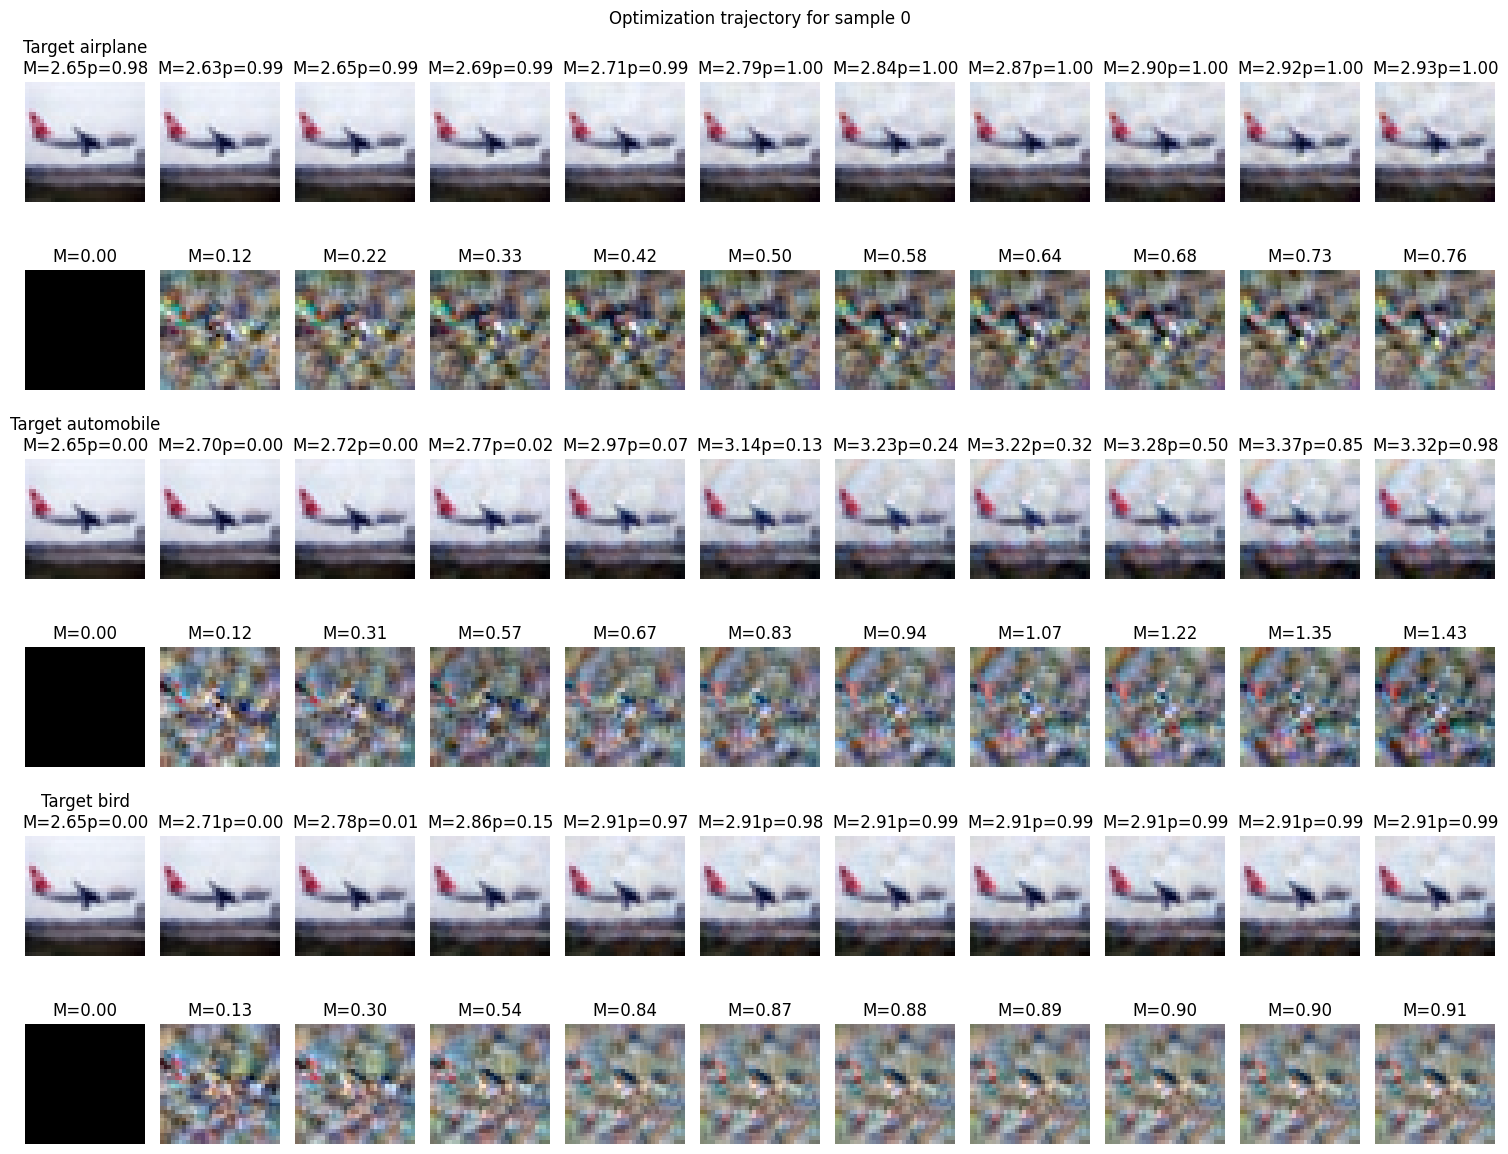

In [42]:
plot_optimization_trajectory_fixed_sample(out, 0, datamodule.class_names, targets=[0, 1, 2], figsizes=((15, 8), (15, 12)))
plt.show()

In [ ]:
torch.save(out, "optimal_images.pth")

In [46]:
out_loaded = torch.load("optimal_images.pth")

/var/folders/jy/x5558th97mjgtzp6f33ryf840000gn/T/ipykernel_59460/595520248.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  out_loaded = torch.load("optimal_images.pth")


## Flatness

In [12]:
from src.eval.flatness import compute_local_energy, plot_local_energy

local_energy = compute_local_energy(
    classifier,
    datamodule.test_dataloader(),
    1000,
    None,
    np.linspace(0.0, 0.5, 6),
    10,
    'mps'
)

Computing Local Energy for various noise levels: 100%|██████████| 6/6 [00:17<00:00,  2.84s/it]


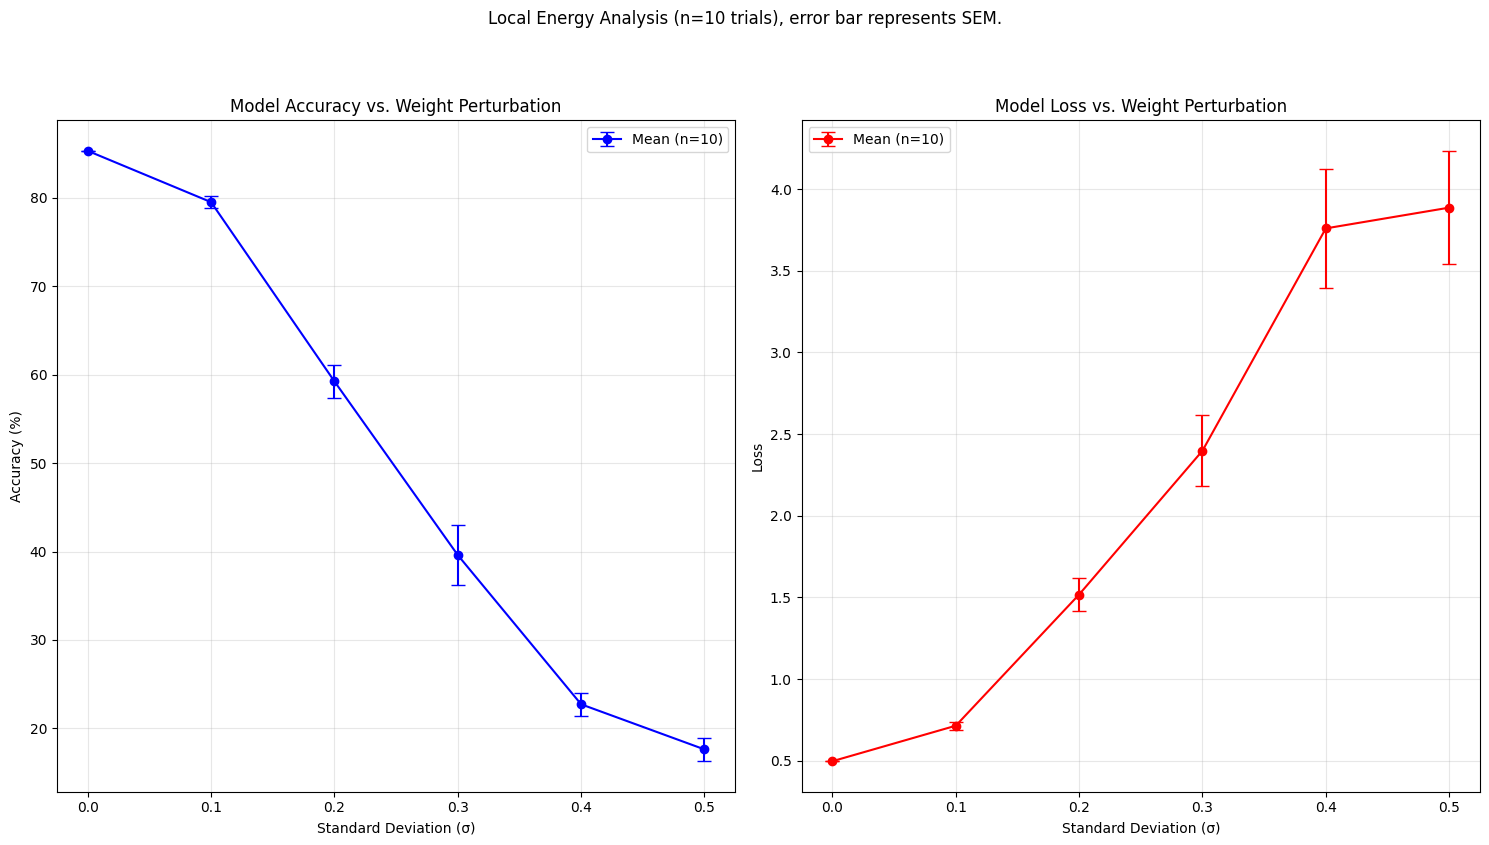

In [ ]:
fig = plot_local_energy(local_energy)
plt.show()

In [2]:
from src.eval.flatness import compute_input_flatness, plot_inputs_flatness


results, gt = compute_input_flatness(
    classifier,
    [(x, y)],
    2,
    np.linspace(0.0, 1.0, 11),
    100,
    'mps'
)

Processing batches:   0%|          | 0/1 [00:03<?, ?it/s]


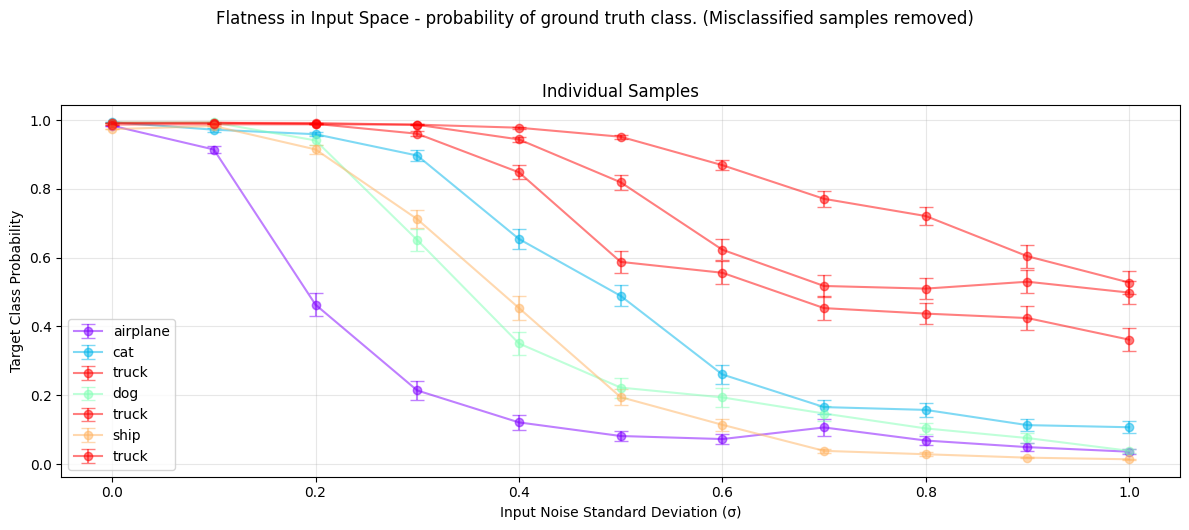

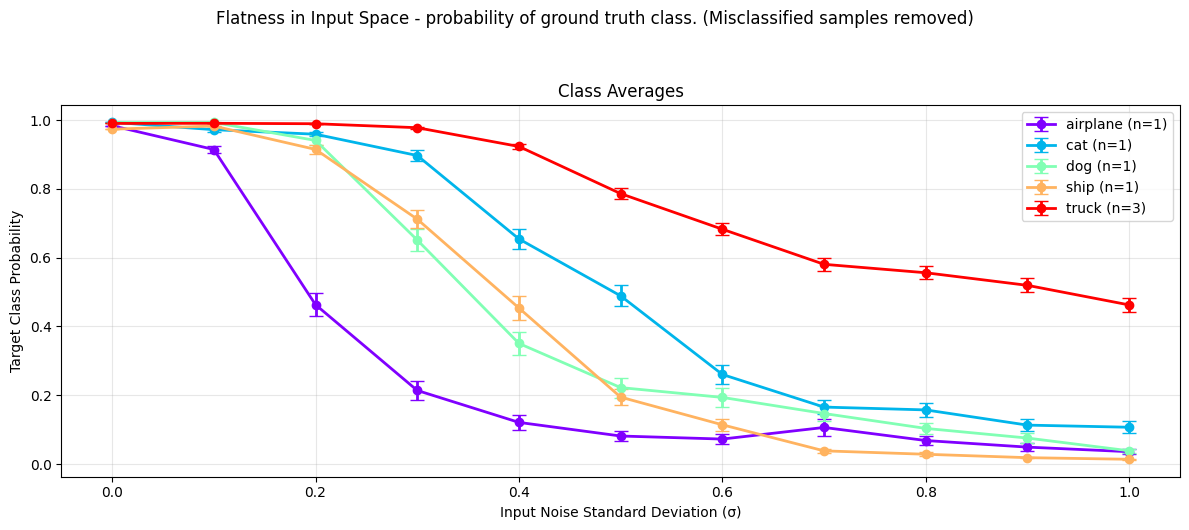

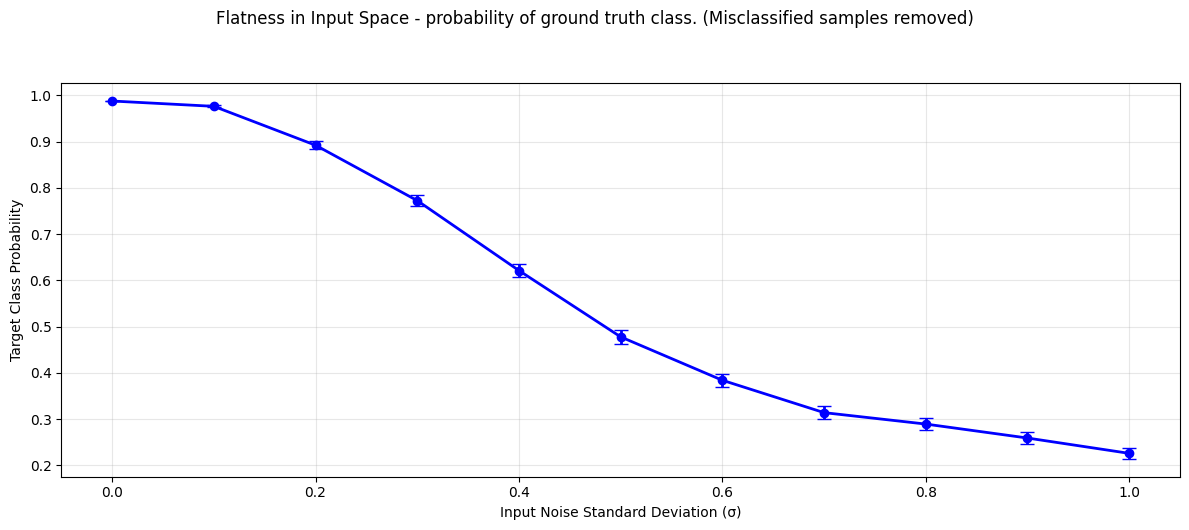

In [5]:
plot_inputs_flatness(results, gt, -1, class_names=datamodule.class_names, filter_misclassified=True, print_summary=False, plot_global_average=True, plot_individual_samples=True)
plt.show()

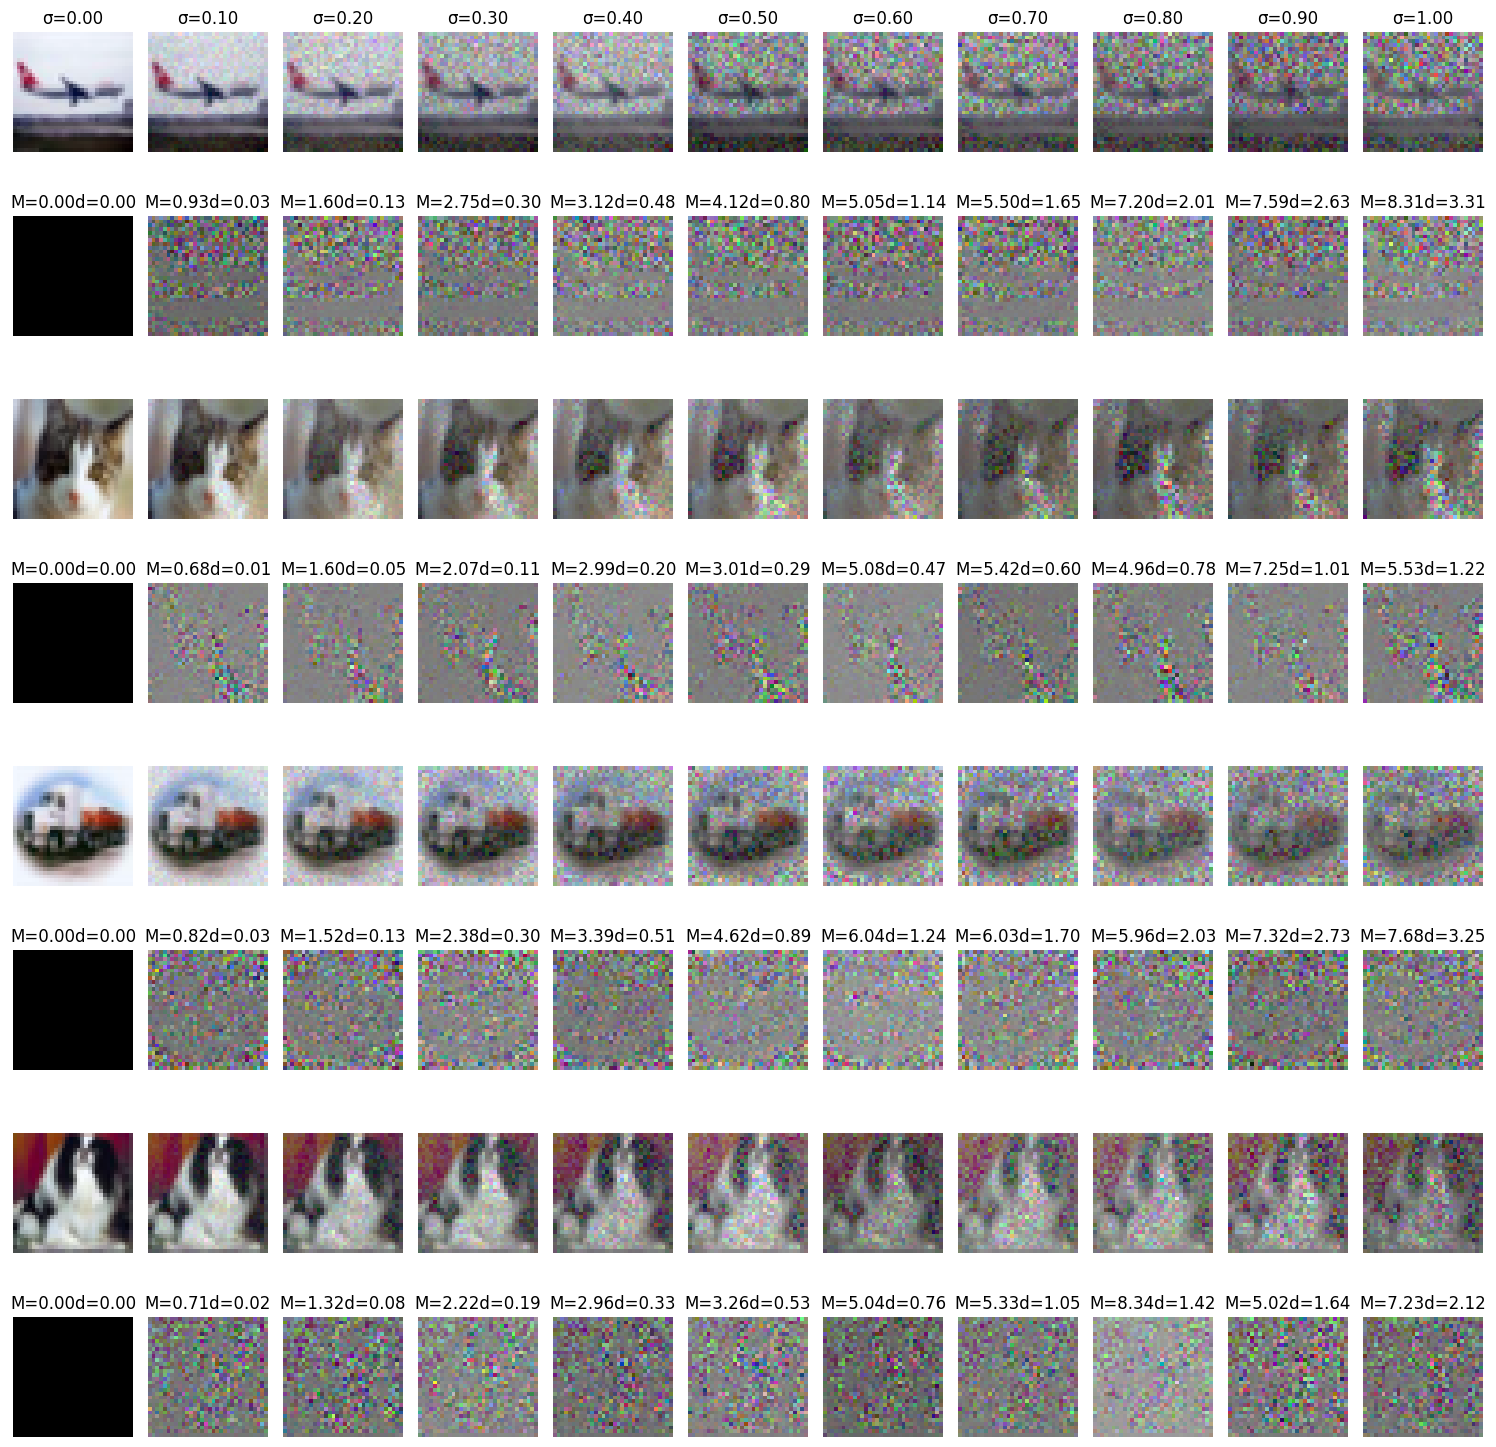

In [5]:
from src.eval.flatness import visualize_input_noise

visualize_input_noise(x)
plt.show()

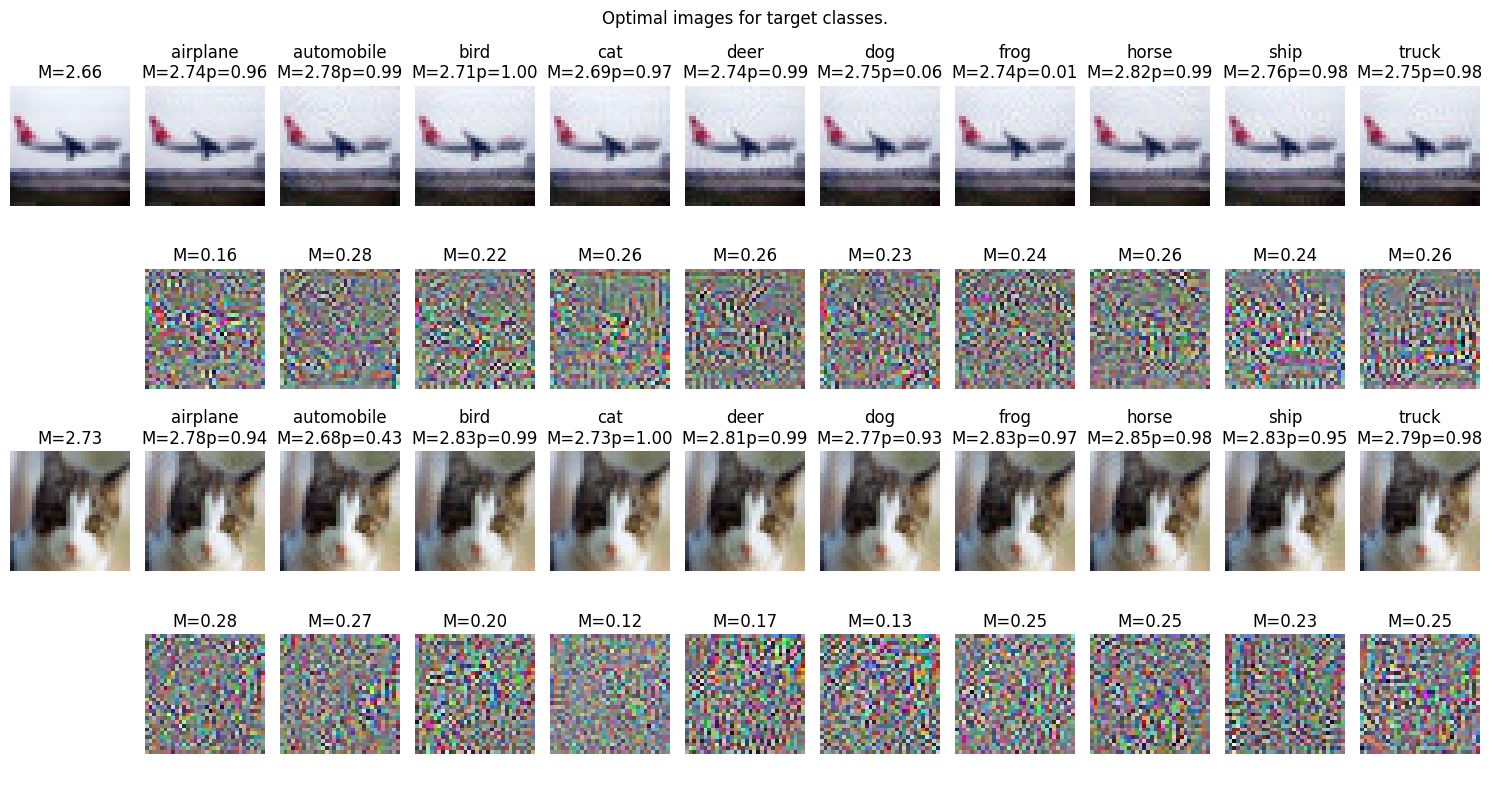

In [9]:
from src.eval.input_gradients import optimize_proba_wrt_data, plot_optimal_images

config = {
    "num_steps": 300,
    "optimizer_cls": torch.optim.AdamW,
    "save_k_intermediate_imgs": 10,
    "logit_transform": None,
    "perturb_weights": True,
    "stddev": 0.2,
    "weights_sample_freq": 10,
    "optimizer_kwargs": {
        "lr": 0.001,
        "weight_decay": 0.01,
    },
}

out = optimize_proba_wrt_data(
    classifier,
    x.clone(),
    list(range(10)),
    config,
    device='mps',
)
plot_optimal_images(out, datamodule.class_names)
plt.show()